# Exercise 3.4.1
Apply skills learned in chapter

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import sys

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../My-Code/')

import timetools as tt

importlib.reload(tt)

<module 'timetools' from '../../My-Code/timetools.py'>

### 3.4.1 Easy: simulate and forecast a random walk
Simulate a different random walk from what we have worked with in this chapter. You can
simply change the seed and get new values.  
1) Generate a random walk of 500 timesteps. Feel free to choose an initial value different from 0. Also, make sure to change the seed by passing a different integer to np.random.seed().  
2) Plot your simulated random walk
3) Test for stationarity
4) Apply a first-order difference
5) Test for stationarity
6) Split your simulated random walk into a training set containing the first 400 timesteps. The remaining 100 timesteps will be your test set.  
7) Apply different naïve forecasting methods and measure the MSE. Which method yields the lowest MSE?
8) Plot your forecasts  
9) Forecast the next timestep over the test set and measure the MSE. Did it decrease?
10) Plot your forecasts

In [2]:
sample_size = 500
startpoint = 10
seed = 123

# sample_size = 1000
# startpoint = 0
# seed = 42

# 1) generate a random walk

np.random.seed(seed)
steps = np.random.standard_normal(size=sample_size)
steps[0] = startpoint
random_walk = np.cumsum(steps)

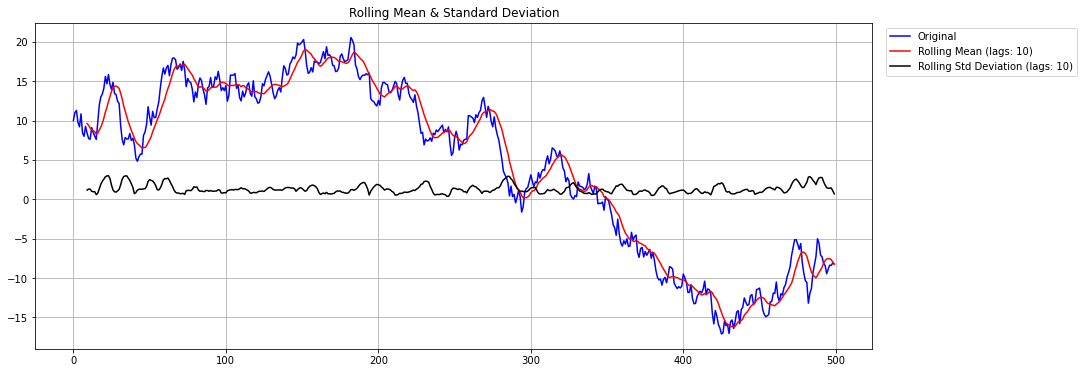

In [3]:
# 2) plot the random walk
tt.plot_for_stationary(pd.Series(random_walk), lags=10)

In [4]:
# 3) test for stationarity
tt.adf(pd.Series(random_walk))

Test Statistic                  -0.751057
p-value                          0.833078
#Lags Used                       0.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64

The time series is not stationary.


In [5]:
# 4) apply first-order difference
random_walk_diff1 = np.diff(random_walk, n=1)

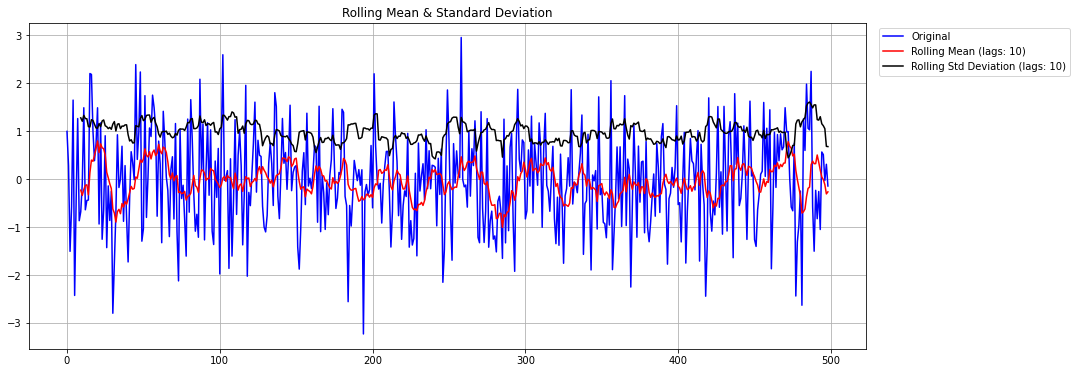

Test Statistic                 -21.573478
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    498.000000
Critical Value (1%)             -3.443549
Critical Value (5%)             -2.867361
Critical Value (10%)            -2.569870
dtype: float64

The time series is stationary.


In [6]:
# 5) test for stationarity
tt.plot_for_stationary(pd.Series(random_walk_diff1), lags=10)
tt.adf(pd.Series(random_walk_diff1))

In [7]:
sample_size*0.8

400.0

In [8]:
# 6) split random walk dataset into train (first 400 steps) and test (last 100 steps)

train, test = random_walk[:int(sample_size*0.8)], random_walk[int(sample_size*0.8):]

In [9]:
# 7) naive forecasting; measure with MSE

index_vals = np.arange(len(train) + 1, sample_size + 1, 1)
df_pred = pd.DataFrame({'value':test}, index=index_vals)
df_pred['pred_mean'] = np.mean(train)
df_pred['pred_last_value'] = train[len(train)-1]

# drift
delta_x = len(train) - 0
delta_y = train[-1] - train[0]
drift = delta_y / delta_x
df_pred['drift'] = index_vals * drift + train[0]     # y = a + b*x
df_pred

,value,pred_mean,pred_last_value,drift
401,-9.495268,8.675826,-11.029358,-11.081932
402,-10.025182,8.675826,-11.029358,-11.134505
403,-10.516155,8.675826,-11.029358,-11.187079
404,-11.825320,8.675826,-11.029358,-11.239652
405,-11.833980,8.675826,-11.029358,-11.292225
...,...,...,...,...
496,-8.891947,8.675826,-11.029358,-16.076404
497,-8.378964,8.675826,-11.029358,-16.128978
498,-8.405887,8.675826,-11.029358,-16.181551
499,-8.094305,8.675826,-11.029358,-16.234125


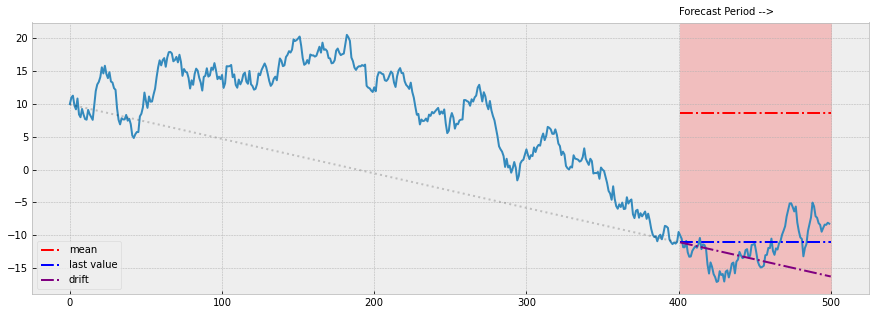

In [25]:
# 8) plot graphs

plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(random_walk)
ax.axvspan(index_vals[0], index_vals[-1], color='red', alpha=0.2)
ax.plot(df_pred['pred_mean'], color='red', ls='-.', label='mean')
ax.plot(df_pred['pred_last_value'], color='blue', ls='-.', label='last value')
ax.plot(df_pred['drift'], color='purple', ls='-.', label='drift')
ax.plot(np.arange(1, len(train)+1) * drift + train[0], color='black', ls='dotted', alpha=0.2)
ax.text(x=len(train), y=max(np.max(train)+3, np.max(test)), s='Forecast Period -->')
plt.legend()
plt.show(); 

### 

In [11]:
# measure MSE

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(df_pred.value, df_pred.pred_mean)
mse_last = mean_squared_error(df_pred.value, df_pred.pred_last_value)
mse_drift = mean_squared_error(df_pred.value, df_pred.drift)

results = pd.DataFrame({'Error': [mse_mean, mse_last, mse_drift]}, index=['mse mean', 'mse last value', 'mse drift'])
results

,Error
mse mean,421.416812
mse last value,9.638938
mse drift,21.384284


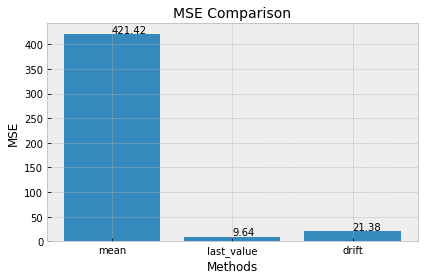

In [12]:
fig, ax = plt.subplots()

ax.bar(
    ['mean', 'last_value', 'drift'], 
    [mse_mean, mse_last, mse_drift], 
    width=0.8)

ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('MSE Comparison', fontsize=14)
ax.text(y=mse_mean+2, x=0, s=round(mse_mean, 2))
ax.text(y=mse_last+2, x=1, s=round(mse_last, 2))
ax.text(y=mse_drift+2, x=2, s=round(mse_drift, 2))

plt.tight_layout()

In [13]:
# 9) Forecast the next timestep over the test set and measure the MSE. Did it decrease?

df_pred2 = pd.DataFrame(random_walk).shift(1)
df_pred2.info()
df_pred2.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       499 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


,0
495,-9.459827
496,-8.891947
497,-8.378964
498,-8.405887
499,-8.094305


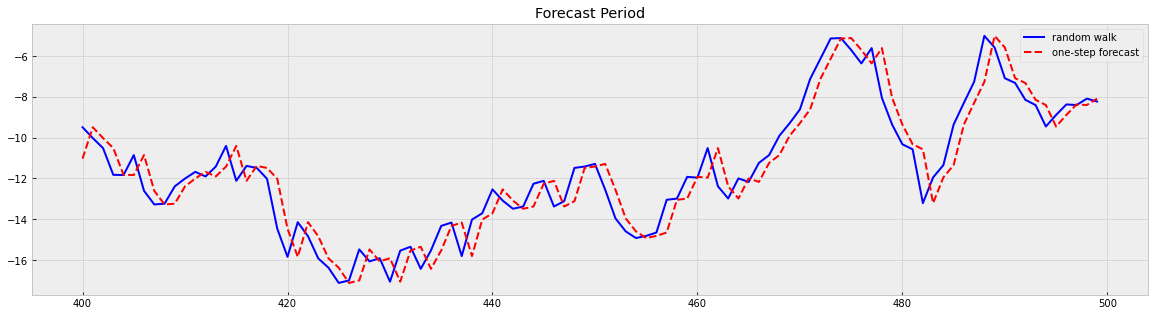

In [24]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(pd.DataFrame(random_walk).tail(len(test)), color='blue', label='random walk')
ax.plot(df_pred2.tail(len(test)), color='red', ls='--', label='one-step forecast')
plt.grid(True)
plt.title('Forecast Period')
plt.legend()
plt.show()

In [22]:
mse_one_step = mean_squared_error(df_pred2.tail(len(test)), 
    pd.DataFrame(random_walk).tail(len(test))) 
print(mse_one_step)

1.0839350626295339


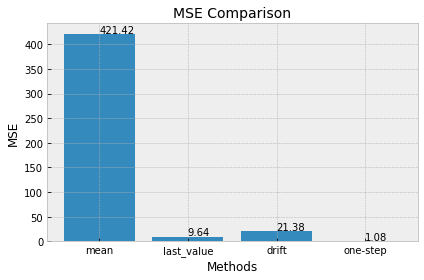

In [21]:
fig, ax = plt.subplots()

ax.bar(
    ['mean', 'last_value', 'drift', 'one-step'], 
    [mse_mean, mse_last, mse_drift, mse_one_step], 
    width=0.8)

ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('MSE Comparison', fontsize=14)
ax.text(y=mse_mean+2, x=0, s=round(mse_mean, 2))
ax.text(y=mse_last+2, x=1, s=round(mse_last, 2))
ax.text(y=mse_drift+2, x=2, s=round(mse_drift, 2))
ax.text(y=mse_one_step+2, x=3, s=round(mse_one_step, 2))

plt.tight_layout()